# Load libraries and set device up

In [1]:
import numpy    as np
import torch.nn as nn
import os
import torch

import libraries.model   as clm
import libraries.dataset as cld

from torch_geometric.loader import DataLoader

# Checking if pytorch can run in GPU, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
target = 'EPA'
folder = 'MP-EPA'

target_folder = f'models/{folder}'

In [3]:
files_names = {
    'dataset_name':      f'{target_folder}/dataset.pt',
    'train_dt_std_name': f'{target_folder}/train_dataset_std.pt',
    'val_dt_std_name':   f'{target_folder}/val_dataset_std.pt',
    'test_dt_std_name':  f'{target_folder}/test_dataset_std.pt',
    'std_param_name':    f'{target_folder}/standardized_parameters.json',
    'dt_param_name':     f'{target_folder}/dataset_parameters.json',
    'uncert_data_name':  f'{target_folder}/uncertainty_data.json',
    'model_name':        f'{target_folder}/model.pt',
    'model_param_name':  f'{target_folder}/model_parameters.json'
}
cld.save_json(files_names, f'{target_folder}/files_names.json')

# Define parameters

In [4]:
n_epochs =      300
batch_size =    128
learning_rate = 0.001
dropout =       0.1
patience =      n_epochs
delta =         2
train_ratio =   0.8
test_ratio =    0.1  # val_ratio = 1 - train_ratio - test_ratio

model_parameters = {
    'n_epochs':      n_epochs,
    'batch_size':    batch_size,
    'learning_rate': learning_rate,
    'dropout':       dropout,
    'patience':      patience,
    'delta':         delta,
    'train_ratio':   train_ratio,
    'test_ratio':    test_ratio
}
cld.save_json(model_parameters, files_names['model_param_name'])

# Generate or load graph database for training

In [5]:
# Try loading the training datasets directly, else generate them
try:
    train_dataset, val_dataset, test_dataset, standardized_parameters = cld.load_datasets(files_names)

except FileNotFoundError:
    if not os.path.exists(files_names['dataset_name']):
        # Generate data
        cld.generate_dataset('datasets/MP_dataset',
                             targets=['EPA', 'bandgap'],
                             data_folder=target_folder)

    # Load the raw dataset, with corresponding labels, and standardize it
    dataset = torch.load(files_names['dataset_name'], weights_only=False)

    # Load dataset parameters
    dataset_parameters = cld.load_json(files_names['dt_param_name'])

    # Determine the index for the desired property
    target_idx = [idx for idx, t in enumerate(dataset_parameters['target']) if t == target][0]

    # Select the target we want
    for data in dataset:
        data.y = torch.tensor([data.y[target_idx]], dtype=torch.float)

    # Split datasets
    train_dataset, val_dataset, test_dataset = cld.split_dataset(train_ratio, test_ratio, dataset)
    del dataset  # Free up CUDA memory

    # Standardize train dataset
    train_dataset, standardized_parameters = cld.standardize_dataset(train_dataset)

    # Standardize test and validation datasets with train parameters
    val_dataset  = cld.standardize_dataset_from_keys(val_dataset,  standardized_parameters)
    test_dataset = cld.standardize_dataset_from_keys(test_dataset, standardized_parameters)

    # Save datasets
    cld.save_datasets(train_dataset, val_dataset, test_dataset, files_names)

    # Save standardized parameters
    cld.save_json(standardized_parameters, files_names['std_param_name'])

# Defining target factor
target_factor = standardized_parameters['target_std'] / standardized_parameters['scale']
targe_mean = standardized_parameters['target_mean']

Number of training   graphs: 35600
Number of validation graphs: 4450
Number of testing    graphs: 4450


Define data loaders.

In [7]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, pin_memory=True)

# Determine number of node-level features in dataset, considering the t_step information
n_node_features = train_dataset[0].num_node_features
del test_dataset  # Free up CUDA memory

# Generate Graph Neural Network model

In [8]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model_name'], purpose='train')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

# Train

Define training optimized and criterion

In [9]:
# MSELoss is by default defined as the mean within the batch
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()

# Initialize early stopping
early_stopping = clm.EarlyStopping(patience=patience, delta=delta, model_name=files_names['model_name'])

In [64]:
import importlib
importlib.reload(cld)

<module 'libraries.dataset' from '/home/claudio/cibran/Work/UPC/CLUE/libraries/dataset.py'>

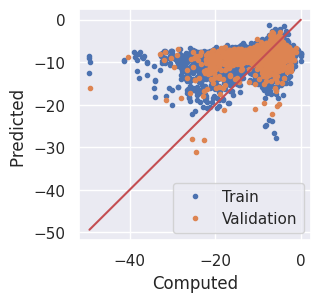

Epoch: 1, Train MAE: 3.1701, Val MAE: 3.0903
Epoch: 2, Train MAE: 3.1663, Val MAE: 3.0759
Epoch: 3, Train MAE: 3.1585, Val MAE: 3.0669
Epoch: 4, Train MAE: 3.1391, Val MAE: 3.0626
Epoch: 5, Train MAE: 3.1396, Val MAE: 3.0570
Epoch: 6, Train MAE: 3.1264, Val MAE: 3.0479
Epoch: 7, Train MAE: 3.1227, Val MAE: 3.0457
Epoch: 8, Train MAE: 3.1117, Val MAE: 3.0345
Epoch: 9, Train MAE: 3.1068, Val MAE: 3.0344
Epoch: 10, Train MAE: 3.0907, Val MAE: 3.0195


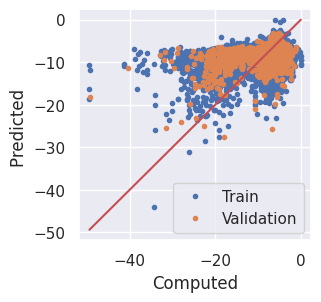

Epoch: 11, Train MAE: 3.0868, Val MAE: 3.0238
Epoch: 12, Train MAE: 3.0996, Val MAE: 3.0171
Epoch: 13, Train MAE: 3.0845, Val MAE: 3.0043
Epoch: 14, Train MAE: 3.0814, Val MAE: 3.0145
Epoch: 15, Train MAE: 3.0698, Val MAE: 2.9919
Epoch: 16, Train MAE: 3.0619, Val MAE: 2.9831
Epoch: 17, Train MAE: 3.0638, Val MAE: 2.9780
Epoch: 18, Train MAE: 3.0549, Val MAE: 3.0067
Epoch: 19, Train MAE: 3.0644, Val MAE: 2.9659
Epoch: 20, Train MAE: 3.0604, Val MAE: 2.9789


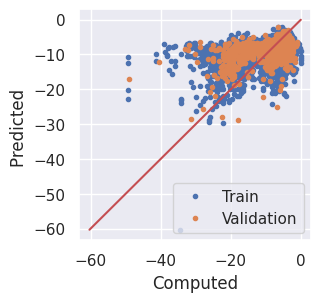

Epoch: 21, Train MAE: 3.0428, Val MAE: 2.9698
Epoch: 22, Train MAE: 3.0490, Val MAE: 2.9929
Epoch: 23, Train MAE: 3.0438, Val MAE: 2.9624
Epoch: 24, Train MAE: 3.0301, Val MAE: 2.9506
Epoch: 25, Train MAE: 3.0301, Val MAE: 2.9625
Epoch: 26, Train MAE: 3.0319, Val MAE: 2.9521
Epoch: 27, Train MAE: 3.0317, Val MAE: 2.9600
Epoch: 28, Train MAE: 3.0240, Val MAE: 2.9489
Epoch: 29, Train MAE: 3.0221, Val MAE: 2.9674
Epoch: 30, Train MAE: 3.0551, Val MAE: 2.9475


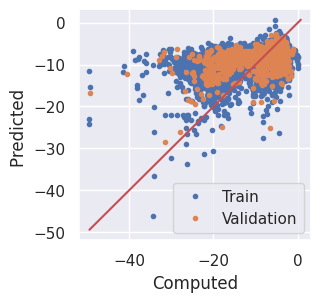

Epoch: 31, Train MAE: 3.0171, Val MAE: 2.9529
Epoch: 32, Train MAE: 3.0080, Val MAE: 2.9472
Epoch: 33, Train MAE: 3.0058, Val MAE: 2.9477
Epoch: 34, Train MAE: 2.9955, Val MAE: 2.9432
Epoch: 35, Train MAE: 3.0058, Val MAE: 2.9404
Epoch: 36, Train MAE: 3.0031, Val MAE: 2.9475
Epoch: 37, Train MAE: 3.0139, Val MAE: 2.9267
Epoch: 38, Train MAE: 2.9837, Val MAE: 2.9543
Epoch: 39, Train MAE: 2.9921, Val MAE: 2.9447
Epoch: 40, Train MAE: 2.9774, Val MAE: 2.9410


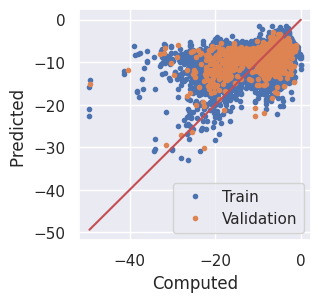

Epoch: 41, Train MAE: 2.9736, Val MAE: 2.9472
Epoch: 42, Train MAE: 2.9683, Val MAE: 2.9313
Epoch: 43, Train MAE: 2.9717, Val MAE: 2.9314
Epoch: 44, Train MAE: 2.9781, Val MAE: 2.9547
Epoch: 45, Train MAE: 2.9783, Val MAE: 2.9383
Epoch: 46, Train MAE: 2.9675, Val MAE: 2.9304
Epoch: 47, Train MAE: 2.9752, Val MAE: 2.9414
Epoch: 48, Train MAE: 2.9691, Val MAE: 2.9598
Epoch: 49, Train MAE: 2.9543, Val MAE: 2.9434
Epoch: 50, Train MAE: 2.9608, Val MAE: 2.9644


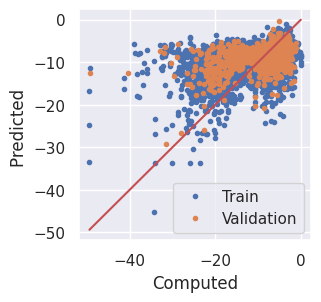

Epoch: 51, Train MAE: 2.9719, Val MAE: 2.9326
Epoch: 52, Train MAE: 2.9460, Val MAE: 2.9388
Epoch: 53, Train MAE: 2.9506, Val MAE: 2.9426
Epoch: 54, Train MAE: 2.9624, Val MAE: 2.9617
Epoch: 55, Train MAE: 2.9511, Val MAE: 2.9517
Epoch: 56, Train MAE: 2.9322, Val MAE: 2.9585
Epoch: 57, Train MAE: 2.9244, Val MAE: 2.9555
Epoch: 58, Train MAE: 2.9213, Val MAE: 2.9733
Epoch: 59, Train MAE: 2.9333, Val MAE: 2.9406
Epoch: 60, Train MAE: 2.9200, Val MAE: 2.9362


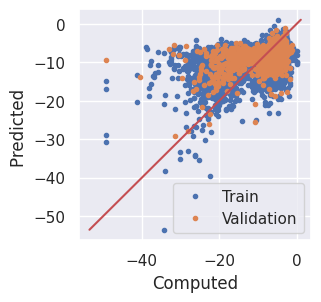

Epoch: 61, Train MAE: 2.9262, Val MAE: 2.9393
Epoch: 62, Train MAE: 2.9469, Val MAE: 2.9198
Epoch: 63, Train MAE: 2.9427, Val MAE: 2.9187
Epoch: 64, Train MAE: 2.9406, Val MAE: 2.9323
Epoch: 65, Train MAE: 2.9127, Val MAE: 2.9259
Epoch: 66, Train MAE: 2.9069, Val MAE: 2.9308
Epoch: 67, Train MAE: 2.9111, Val MAE: 2.9055
Epoch: 68, Train MAE: 2.9101, Val MAE: 2.9298
Epoch: 69, Train MAE: 2.9097, Val MAE: 2.9381
Epoch: 70, Train MAE: 2.9166, Val MAE: 2.9291


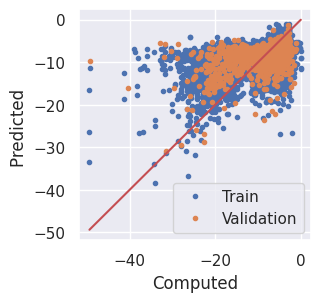

Epoch: 71, Train MAE: 2.9080, Val MAE: 2.9275
Epoch: 72, Train MAE: 2.8978, Val MAE: 2.9181
Epoch: 73, Train MAE: 2.8809, Val MAE: 2.9198
Epoch: 74, Train MAE: 2.9072, Val MAE: 2.9159
Epoch: 75, Train MAE: 2.8963, Val MAE: 2.9232
Epoch: 76, Train MAE: 2.8826, Val MAE: 2.9445
Epoch: 77, Train MAE: 2.8783, Val MAE: 2.9088
Epoch: 78, Train MAE: 2.8682, Val MAE: 2.9133
Epoch: 79, Train MAE: 2.8671, Val MAE: 2.9267
Epoch: 80, Train MAE: 2.8725, Val MAE: 2.9503


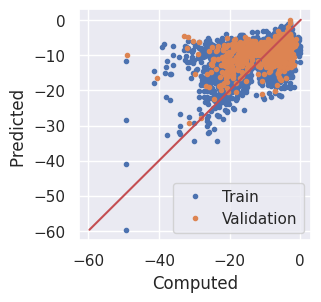

Epoch: 81, Train MAE: 2.8725, Val MAE: 2.9097
Epoch: 82, Train MAE: 2.8574, Val MAE: 2.9186
Epoch: 83, Train MAE: 2.8704, Val MAE: 2.9233
Epoch: 84, Train MAE: 2.8832, Val MAE: 2.9357
Epoch: 85, Train MAE: 2.8844, Val MAE: 2.9108
Epoch: 86, Train MAE: 2.8550, Val MAE: 2.9092
Epoch: 87, Train MAE: 2.8667, Val MAE: 2.9519
Epoch: 88, Train MAE: 2.8837, Val MAE: 2.9545
Epoch: 89, Train MAE: 2.8728, Val MAE: 2.9082
Epoch: 90, Train MAE: 2.8746, Val MAE: 2.9241


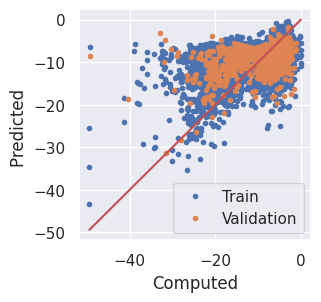

Epoch: 91, Train MAE: 2.8599, Val MAE: 2.9024
Epoch: 92, Train MAE: 2.8665, Val MAE: 2.8998
Epoch: 93, Train MAE: 2.8781, Val MAE: 2.9188
Epoch: 94, Train MAE: 2.8807, Val MAE: 2.9027
Epoch: 95, Train MAE: 2.8452, Val MAE: 2.9074
Epoch: 96, Train MAE: 2.8438, Val MAE: 2.9090
Epoch: 97, Train MAE: 2.8404, Val MAE: 2.9027
Epoch: 98, Train MAE: 2.8318, Val MAE: 2.9270
Epoch: 99, Train MAE: 2.8411, Val MAE: 2.9230
Epoch: 100, Train MAE: 2.8322, Val MAE: 2.9066


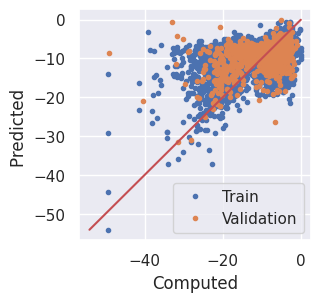

Epoch: 101, Train MAE: 2.8257, Val MAE: 2.9250
Epoch: 102, Train MAE: 2.8360, Val MAE: 2.9317
Epoch: 103, Train MAE: 2.8337, Val MAE: 2.9165
Epoch: 104, Train MAE: 2.8371, Val MAE: 2.9311
Epoch: 105, Train MAE: 2.8330, Val MAE: 2.9042
Epoch: 106, Train MAE: 2.8188, Val MAE: 2.9347
Epoch: 107, Train MAE: 2.8334, Val MAE: 2.9740
Epoch: 108, Train MAE: 2.8432, Val MAE: 2.9055
Epoch: 109, Train MAE: 2.8098, Val MAE: 2.9186
Epoch: 110, Train MAE: 2.8406, Val MAE: 2.9315


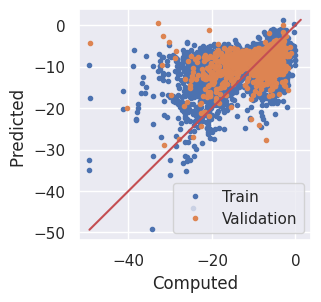

Epoch: 111, Train MAE: 2.8437, Val MAE: 2.9563
Epoch: 112, Train MAE: 2.7984, Val MAE: 2.9654
Epoch: 113, Train MAE: 2.8172, Val MAE: 2.9245
Epoch: 114, Train MAE: 2.8237, Val MAE: 2.9388
Epoch: 115, Train MAE: 2.8399, Val MAE: 2.9697
Epoch: 116, Train MAE: 2.7992, Val MAE: 2.9836
Epoch: 117, Train MAE: 2.8199, Val MAE: 2.9266
Epoch: 118, Train MAE: 2.7959, Val MAE: 2.9812
Epoch: 119, Train MAE: 2.8028, Val MAE: 2.9106
Epoch: 120, Train MAE: 2.8110, Val MAE: 2.9185


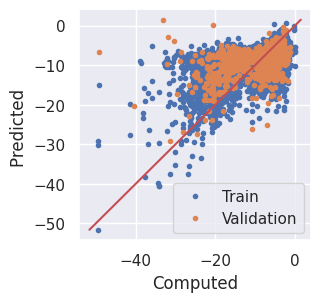

Epoch: 121, Train MAE: 2.7806, Val MAE: 2.9437
Epoch: 122, Train MAE: 2.7951, Val MAE: 2.9269
Epoch: 123, Train MAE: 2.7992, Val MAE: 2.9288
Epoch: 124, Train MAE: 2.7725, Val MAE: 2.9583
Epoch: 125, Train MAE: 2.7901, Val MAE: 2.9452
Epoch: 126, Train MAE: 2.8284, Val MAE: 2.9468
Epoch: 127, Train MAE: 2.7636, Val MAE: 2.9447
Epoch: 128, Train MAE: 2.8022, Val MAE: 2.9352
Epoch: 129, Train MAE: 2.7599, Val MAE: 2.9683
Epoch: 130, Train MAE: 2.7592, Val MAE: 2.9631


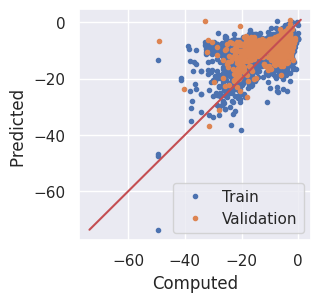

Epoch: 131, Train MAE: 2.7976, Val MAE: 2.8765
Epoch: 132, Train MAE: 2.7757, Val MAE: 2.9279
Epoch: 133, Train MAE: 2.7586, Val MAE: 2.9294
Epoch: 134, Train MAE: 2.7791, Val MAE: 2.9554
Epoch: 135, Train MAE: 2.7735, Val MAE: 2.9256
Epoch: 136, Train MAE: 2.7653, Val MAE: 2.9549
Epoch: 137, Train MAE: 2.7980, Val MAE: 2.9860
Epoch: 138, Train MAE: 2.7677, Val MAE: 2.9175
Epoch: 139, Train MAE: 2.7596, Val MAE: 2.9183
Epoch: 140, Train MAE: 2.7593, Val MAE: 2.9239


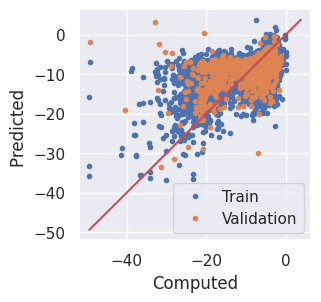

Epoch: 141, Train MAE: 2.7698, Val MAE: 2.9576
Epoch: 142, Train MAE: 2.7594, Val MAE: 2.9772
Epoch: 143, Train MAE: 2.7717, Val MAE: 2.9479
Epoch: 144, Train MAE: 2.7455, Val MAE: 2.9980
Epoch: 145, Train MAE: 2.7780, Val MAE: 2.9802
Epoch: 146, Train MAE: 2.7709, Val MAE: 2.9874
Epoch: 147, Train MAE: 2.7764, Val MAE: 2.9785
Epoch: 148, Train MAE: 2.7768, Val MAE: 2.9727
Epoch: 149, Train MAE: 2.8028, Val MAE: 2.9714
Epoch: 150, Train MAE: 2.7866, Val MAE: 2.9703


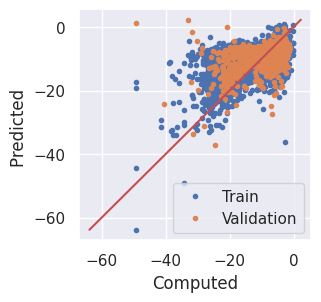

Epoch: 151, Train MAE: 2.7492, Val MAE: 2.9675
Epoch: 152, Train MAE: 2.7280, Val MAE: 2.9572
Epoch: 153, Train MAE: 2.7500, Val MAE: 2.9839
Epoch: 154, Train MAE: 2.7449, Val MAE: 3.0129
Epoch: 155, Train MAE: 2.7596, Val MAE: 3.0342
Epoch: 156, Train MAE: 2.7682, Val MAE: 2.9855
Epoch: 157, Train MAE: 2.7467, Val MAE: 2.9755
Epoch: 158, Train MAE: 2.7249, Val MAE: 3.0312
Epoch: 159, Train MAE: 2.7439, Val MAE: 2.9974
Epoch: 160, Train MAE: 2.7438, Val MAE: 2.9450


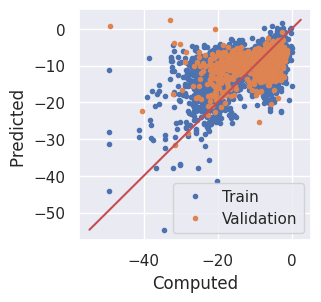

Epoch: 161, Train MAE: 2.7544, Val MAE: 2.9472
Epoch: 162, Train MAE: 2.7464, Val MAE: 2.9748
Epoch: 163, Train MAE: 2.7521, Val MAE: 3.0150
Epoch: 164, Train MAE: 2.7236, Val MAE: 2.9538
Epoch: 165, Train MAE: 2.7539, Val MAE: 2.9806
Epoch: 166, Train MAE: 2.7415, Val MAE: 3.0287
Epoch: 167, Train MAE: 2.7517, Val MAE: 2.9460
Epoch: 168, Train MAE: 2.7432, Val MAE: 2.9748
Epoch: 169, Train MAE: 2.7253, Val MAE: 2.9790
Epoch: 170, Train MAE: 2.7376, Val MAE: 2.9368


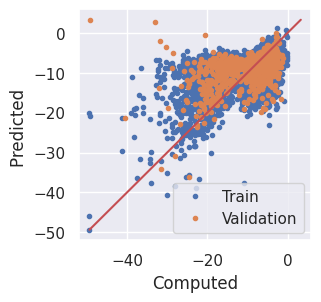

Epoch: 171, Train MAE: 2.7398, Val MAE: 2.9409
Epoch: 172, Train MAE: 2.7221, Val MAE: 2.9951
Epoch: 173, Train MAE: 2.7249, Val MAE: 2.9336
Epoch: 174, Train MAE: 2.7287, Val MAE: 2.9588
Epoch: 175, Train MAE: 2.7239, Val MAE: 2.9865
Epoch: 176, Train MAE: 2.7281, Val MAE: 2.9662
Epoch: 177, Train MAE: 2.7343, Val MAE: 2.9450
Epoch: 178, Train MAE: 2.7179, Val MAE: 2.9947
Epoch: 179, Train MAE: 2.7164, Val MAE: 2.9579
Epoch: 180, Train MAE: 2.7045, Val MAE: 2.9269


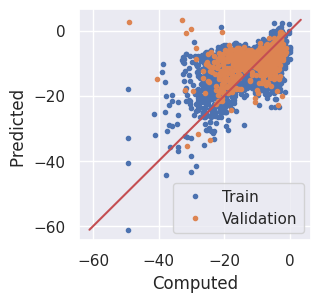

Epoch: 181, Train MAE: 2.7137, Val MAE: 2.9759
Epoch: 182, Train MAE: 2.8026, Val MAE: 3.0126
Epoch: 183, Train MAE: 2.8172, Val MAE: 3.0221
Epoch: 184, Train MAE: 2.7711, Val MAE: 2.9712
Epoch: 185, Train MAE: 2.7268, Val MAE: 2.9679
Epoch: 186, Train MAE: 2.7530, Val MAE: 2.9761
Epoch: 187, Train MAE: 2.7238, Val MAE: 2.9452
Epoch: 188, Train MAE: 2.6989, Val MAE: 2.9631
Epoch: 189, Train MAE: 2.7338, Val MAE: 2.9654
Epoch: 190, Train MAE: 2.6875, Val MAE: 3.0083


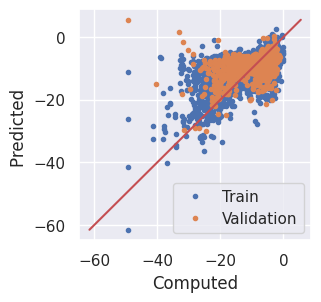

Epoch: 191, Train MAE: 2.7076, Val MAE: 2.9519
Epoch: 192, Train MAE: 2.7096, Val MAE: 2.9649
Epoch: 193, Train MAE: 2.7186, Val MAE: 3.0089
Epoch: 194, Train MAE: 2.7156, Val MAE: 2.9396
Epoch: 195, Train MAE: 2.6812, Val MAE: 2.9796
Epoch: 196, Train MAE: 2.7316, Val MAE: 2.9135
Epoch: 197, Train MAE: 2.6916, Val MAE: 2.9499
Epoch: 198, Train MAE: 2.6896, Val MAE: 2.9474
Epoch: 199, Train MAE: 2.6721, Val MAE: 2.9813
Epoch: 200, Train MAE: 2.6813, Val MAE: 2.9645


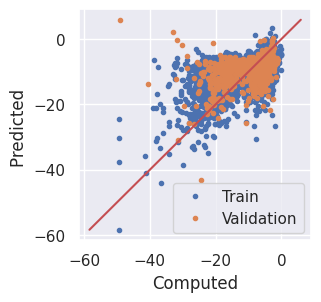

Epoch: 201, Train MAE: 2.6976, Val MAE: 2.9943
Epoch: 202, Train MAE: 2.7157, Val MAE: 2.9485
Epoch: 203, Train MAE: 2.6896, Val MAE: 2.9805
Epoch: 204, Train MAE: 2.6666, Val MAE: 2.9511
Epoch: 205, Train MAE: 2.6867, Val MAE: 2.9269
Epoch: 206, Train MAE: 2.6933, Val MAE: 2.9959
Epoch: 207, Train MAE: 2.6691, Val MAE: 2.9366
Epoch: 208, Train MAE: 2.6505, Val MAE: 2.9878
Epoch: 209, Train MAE: 2.6843, Val MAE: 2.9322
Epoch: 210, Train MAE: 2.6687, Val MAE: 2.9598


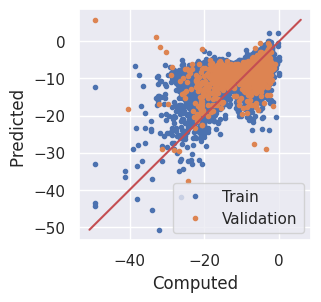

Epoch: 211, Train MAE: 2.6807, Val MAE: 2.9836
Epoch: 212, Train MAE: 2.7082, Val MAE: 2.9861
Epoch: 213, Train MAE: 2.7124, Val MAE: 3.0042
Epoch: 214, Train MAE: 2.7582, Val MAE: 2.9461
Epoch: 215, Train MAE: 2.6829, Val MAE: 2.9608
Epoch: 216, Train MAE: 2.7084, Val MAE: 2.9251
Epoch: 217, Train MAE: 2.6828, Val MAE: 2.9714
Epoch: 218, Train MAE: 2.6788, Val MAE: 2.9230
Epoch: 219, Train MAE: 2.6798, Val MAE: 2.9776
Epoch: 220, Train MAE: 2.6653, Val MAE: 2.9790


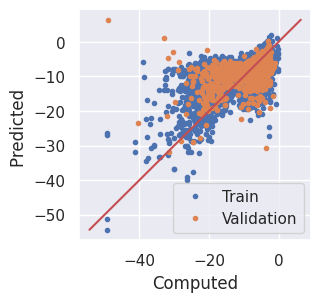

Epoch: 221, Train MAE: 2.6706, Val MAE: 2.9416
Epoch: 222, Train MAE: 2.6932, Val MAE: 2.9881
Epoch: 223, Train MAE: 2.6554, Val MAE: 2.9675
Epoch: 224, Train MAE: 2.6815, Val MAE: 2.9815
Epoch: 225, Train MAE: 2.6520, Val MAE: 2.9644
Epoch: 226, Train MAE: 2.6922, Val MAE: 2.9264
Epoch: 227, Train MAE: 2.6659, Val MAE: 2.9965
Epoch: 228, Train MAE: 2.6777, Val MAE: 2.9583
Epoch: 229, Train MAE: 2.6631, Val MAE: 3.0118
Epoch: 230, Train MAE: 2.6422, Val MAE: 2.9563


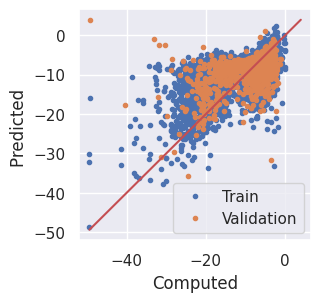

Epoch: 231, Train MAE: 2.6439, Val MAE: 2.9679
Epoch: 232, Train MAE: 2.7314, Val MAE: 2.9422
Epoch: 233, Train MAE: 2.6485, Val MAE: 2.9455
Epoch: 234, Train MAE: 2.6631, Val MAE: 2.9750
Epoch: 235, Train MAE: 2.6670, Val MAE: 2.9424
Epoch: 236, Train MAE: 2.6752, Val MAE: 2.9785
Epoch: 237, Train MAE: 2.6507, Val MAE: 2.9352
Epoch: 238, Train MAE: 2.6376, Val MAE: 2.9914
Epoch: 239, Train MAE: 2.6692, Val MAE: 2.9697
Epoch: 240, Train MAE: 2.6490, Val MAE: 2.9453


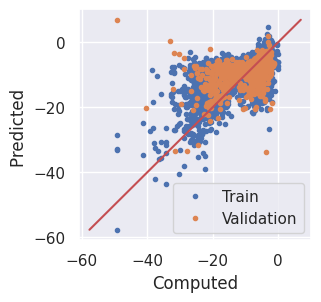

Epoch: 241, Train MAE: 2.6628, Val MAE: 3.0104
Epoch: 242, Train MAE: 2.6572, Val MAE: 2.9913
Epoch: 243, Train MAE: 2.6496, Val MAE: 2.9659
Epoch: 244, Train MAE: 2.8458, Val MAE: 2.9707
Epoch: 245, Train MAE: 2.7040, Val MAE: 2.9543
Epoch: 246, Train MAE: 2.6484, Val MAE: 2.9582
Epoch: 247, Train MAE: 2.6348, Val MAE: 2.9775
Epoch: 248, Train MAE: 2.6669, Val MAE: 2.9915
Epoch: 249, Train MAE: 2.6299, Val MAE: 2.9824
Epoch: 250, Train MAE: 2.6385, Val MAE: 2.9975


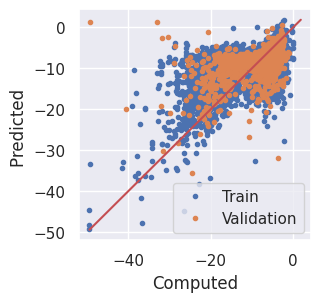

Epoch: 251, Train MAE: 2.6547, Val MAE: 2.9425
Epoch: 252, Train MAE: 2.6293, Val MAE: 2.9605
Epoch: 253, Train MAE: 2.6702, Val MAE: 2.9864
Epoch: 254, Train MAE: 2.7193, Val MAE: 2.9669
Epoch: 255, Train MAE: 2.6826, Val MAE: 2.9682
Epoch: 256, Train MAE: 2.6044, Val MAE: 2.9930
Epoch: 257, Train MAE: 2.6221, Val MAE: 2.9579
Epoch: 258, Train MAE: 2.6700, Val MAE: 2.9827
Epoch: 259, Train MAE: 2.6587, Val MAE: 2.9967
Epoch: 260, Train MAE: 2.6562, Val MAE: 2.9754


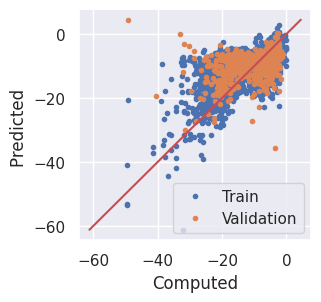

Epoch: 261, Train MAE: 2.6129, Val MAE: 2.9589
Epoch: 262, Train MAE: 2.6362, Val MAE: 2.9684
Epoch: 263, Train MAE: 2.6423, Val MAE: 2.9926
Epoch: 264, Train MAE: 2.6335, Val MAE: 2.9956
Epoch: 265, Train MAE: 2.6422, Val MAE: 3.0029
Epoch: 266, Train MAE: 2.6277, Val MAE: 2.9723
Epoch: 267, Train MAE: 2.6409, Val MAE: 2.9760
Epoch: 268, Train MAE: 2.6979, Val MAE: 2.9867
Epoch: 269, Train MAE: 2.6677, Val MAE: 2.9639
Epoch: 270, Train MAE: 2.6460, Val MAE: 3.0233


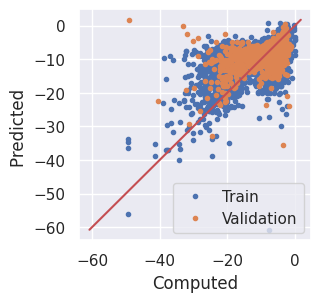

Epoch: 271, Train MAE: 2.7482, Val MAE: 2.9588
Epoch: 272, Train MAE: 2.6631, Val MAE: 2.9960
Epoch: 273, Train MAE: 2.6583, Val MAE: 2.9890
Epoch: 274, Train MAE: 2.7161, Val MAE: 2.9803
Epoch: 275, Train MAE: 2.6503, Val MAE: 2.9593
Epoch: 276, Train MAE: 2.6268, Val MAE: 3.0029
Epoch: 277, Train MAE: 2.6252, Val MAE: 2.9800
Epoch: 278, Train MAE: 2.6221, Val MAE: 2.9696
Epoch: 279, Train MAE: 2.6406, Val MAE: 2.9674
Epoch: 280, Train MAE: 2.6627, Val MAE: 2.9572


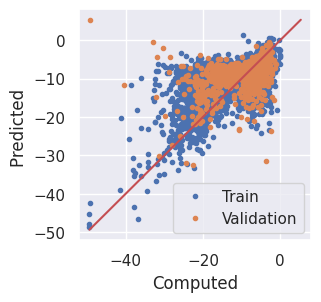

Epoch: 281, Train MAE: 2.6241, Val MAE: 2.9793
Epoch: 282, Train MAE: 2.6192, Val MAE: 2.9573
Epoch: 283, Train MAE: 2.6360, Val MAE: 2.9915
Epoch: 284, Train MAE: 2.6398, Val MAE: 2.9997
Epoch: 285, Train MAE: 2.6442, Val MAE: 3.0035
Epoch: 286, Train MAE: 2.6226, Val MAE: 2.9791
Epoch: 287, Train MAE: 2.6089, Val MAE: 2.9482
Epoch: 288, Train MAE: 2.6244, Val MAE: 2.9291
Epoch: 289, Train MAE: 2.6344, Val MAE: 2.9523
Epoch: 290, Train MAE: 2.6072, Val MAE: 2.9767


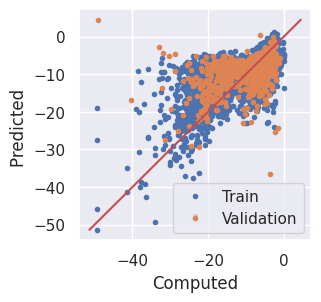

Epoch: 291, Train MAE: 2.6350, Val MAE: 2.9580
Epoch: 292, Train MAE: 2.6367, Val MAE: 2.9810
Epoch: 293, Train MAE: 2.6625, Val MAE: 2.9783
Epoch: 294, Train MAE: 2.5939, Val MAE: 2.9792
Epoch: 295, Train MAE: 2.6251, Val MAE: 2.9836
Epoch: 296, Train MAE: 2.6088, Val MAE: 3.0019
Epoch: 297, Train MAE: 2.6181, Val MAE: 2.9591
Epoch: 298, Train MAE: 2.6098, Val MAE: 2.9911
Epoch: 299, Train MAE: 2.6173, Val MAE: 2.9530
Epoch: 300, Train MAE: 2.7287, Val MAE: 3.0054


In [65]:
# Train the model
train_losses = []
val_losses   = []
for epoch in np.arange(0, n_epochs):
    train_loss, train_predictions, train_ground_truths = clm.train(model, criterion, train_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'],
                                                                   optimizer)
    val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                                   target_factor,
                                                                   standardized_parameters['target_mean'])

    # Convert to original units
    train_loss = np.sum(np.sqrt(train_loss) * target_factor)
    val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)

    if epoch%10 == 0:
        cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                        validation=np.array([val_ground_truths, val_predictions]))
    
    # Append losses
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Check early stopping criteria
    early_stopping(val_loss, model)

    if early_stopping.early_stop:
        print('Early stopping')
        break

    print(f'Epoch: {epoch+1}, Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}')

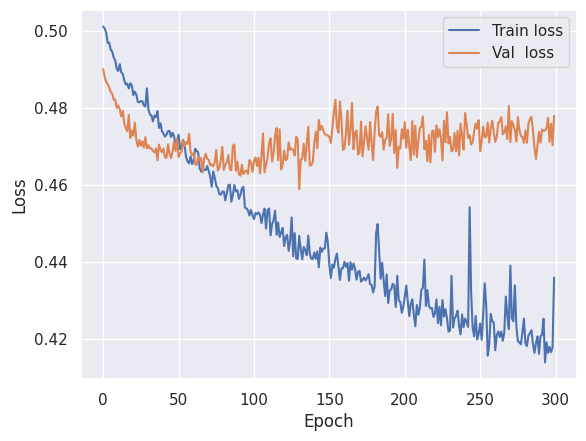

In [66]:
cld.losses_plot(train_losses=train_losses,
                val_losses=val_losses,
                to_log=True)

# Check test data

In [67]:
model = clm.load_model(n_node_features, dropout, device, model_name=files_names['model_name'], purpose='eval')
model

DataParallel(
  (module): GCNN(
    (conv1): GraphConv(4, 32)
    (conv2): GraphConv(32, 32)
    (lin1): Linear(in_features=32, out_features=32, bias=True)
    (lin2): Linear(in_features=32, out_features=16, bias=True)
    (lin): Linear(in_features=16, out_features=1, bias=True)
  )
)

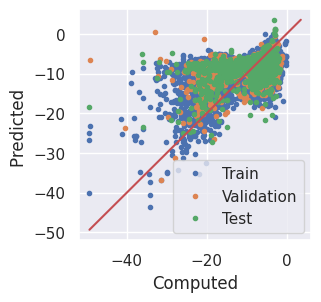

Train MAE: 2.6951, Val MAE: 2.8765, Test MAE: 2.9660


In [70]:
train_loss, train_predictions, train_ground_truths = clm.test(model, criterion, train_loader,
                                                              target_factor,
                                                              standardized_parameters['target_mean'])
val_loss,   val_predictions,   val_ground_truths   =  clm.test(model, criterion, val_loader,
                                                               target_factor,
                                                               standardized_parameters['target_mean'])
test_loss,  test_predictions,  test_ground_truths  =  clm.test(model, criterion, test_loader,
                                                               target_factor,
                                                               standardized_parameters['target_mean'])

# Pass to energy units (same as initial Fv)
train_loss = np.sum(np.sqrt(train_loss) * target_factor)
val_loss   = np.sum(np.sqrt(val_loss)   * target_factor)
test_loss  = np.sum(np.sqrt(test_loss)  * target_factor)

cld.parity_plot(train=np.array([train_ground_truths, train_predictions]),
                validation=np.array([val_ground_truths, val_predictions]),
                test=np.array([test_ground_truths, test_predictions]),
                save_to=f'{target_folder}/{target}-GCNN-training.pdf')

print(f'Train MAE: {train_loss:.4f}, Val MAE: {val_loss:.4f}, Test MAE: {test_loss:.4f}')

# Generate uncertainties and save

In [72]:
dataset = [data for dataset in [train_dataset, val_dataset] for data in dataset]

loader = DataLoader(dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

loss, predictions, ground_truths = clm.test(model, criterion, loader,
                                            target_factor,
                                            standardized_parameters['target_mean'])

# label: uncertainty = ground-truth - prediction
uncertainties = ground_truths - predictions

# Generate dictionary with uncertainty data
uncertainty_data = {}
for idx in range(len(dataset)):
    uncertainty_data.update(
        {dataset[idx].label: float(uncertainties[idx])}
    )

# Dump the dictionary with numpy arrays to a JSON file
cld.save_json(uncertainty_data, files_names['uncert_data_name'])